<a href="https://colab.research.google.com/github/sdhilip200/Content-Based-Recommendation---Good-Reads-data/blob/master/Recommendation_Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
import re
import string
import random
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from matplotlib import pyplot
from gensim.models import KeyedVectors

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lihaokx\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Reading the data
df = pd.read_csv("data.csv")
df.iloc[2310]

Unnamed: 0                                                   2379
Desc            NOS4A2 is a spine-tingling novel of supernatur...
Unnamed: 0.1                                                  NaN
author                                                   Joe Hill
genre                                                 Non-Fiction
image_link      https://i.gr-assets.com/images/S/compressed.ph...
rating                                                       4.07
title                                                      NOS4A2
Name: 2310, dtype: object

# Text Preprocessing

In [3]:
#Utitlity functions for removing ASCII characters, converting lower case, removing stop words, html and punctuation from description

def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

def make_lower_case(text):
    return text.lower()

def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

In [5]:
df['Desc'] = df['Desc'].astype(str)

In [6]:
df['cleaned'] = df['Desc'].apply(_removeNonAscii)

df['cleaned'] = df.cleaned.apply(func = make_lower_case)
df['cleaned'] = df.cleaned.apply(func = remove_stop_words)
df['cleaned'] = df.cleaned.apply(func=remove_punctuation)
df['cleaned'] = df.cleaned.apply(func=remove_html)


# Building Average Word2Vec Model

In [12]:
# Downloading the Google pretrained Word2Vec Model
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [9]:
EMBEDDING_FILE = 'GoogleNews-vectors-negative300.bin.gz'
# google_word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)


In [10]:
#splitting the description into words

i = 0
corpus = []
for words in df['cleaned']:
    corpus.append(words.split())


In [13]:
%%time
# Training our corpus with Google Pretrained Model
google_model = Word2Vec(size = 300, window=5, min_count = 2, workers = -1)
google_model.build_vocab(corpus)
# print( google_model.wv['steve'])

#model.intersect_word2vec_format('./word2vec/GoogleNews-vectors-negative300.bin', lockf=1.0, binary=True)

# google_model.intersect_word2vec_format(EMBEDDING_FILE, lockf=1.0, binary=True)
# print(google_model.wv['steve'])
google_model.train(corpus, total_examples=google_model.corpus_count, epochs = 5)


Wall time: 3.19 s


(0, 0)

In [14]:
len(google_model.wv.vocab)

15893

In [17]:
type(google_model.wv.vocab)

dict

In [18]:
len(google_model.wv['steve'])

300

In [19]:
google_model.wv.most_similar(positive=["steve"])

[('diminished', 0.2052651047706604),
 ('rebel', 0.20501896739006042),
 ('magical', 0.20030614733695984),
 ('melinda', 0.19981421530246735),
 ('procedure', 0.19366957247257233),
 ('pitching', 0.19157393276691437),
 ('trusting', 0.18447336554527283),
 ('allens', 0.18414145708084106),
 ('moth', 0.18241246044635773),
 ('feverish', 0.18169176578521729)]

In [20]:
google_model.wv.most_similar(positive=["job"])

[('manipulator', 0.22511255741119385),
 ('phase', 0.2143009603023529),
 ('negotiations', 0.21257969737052917),
 ('possessions', 0.20566469430923462),
 ('possibly', 0.2009945809841156),
 ('ice', 0.198929563164711),
 ('electric', 0.19836673140525818),
 ('shabby', 0.195439875125885),
 ('bootstrapping', 0.19276292622089386),
 ('faerie', 0.19182205200195312)]

In [21]:
# Generate the average word2vec for the each book description

def vectors(x):
    
    # Creating a list for storing the vectors (description into vectors)
    global word_embeddings
    word_embeddings = []

    # Reading the each book description 
    for line in df['cleaned']:
        avgword2vec = None
        count = 0
        for word in line.split():
            if word in google_model.wv.vocab:
                count += 1
                if avgword2vec is None:
                    avgword2vec = google_model[word]
                else:
                    avgword2vec = avgword2vec + google_model[word]
                
        if avgword2vec is not None:
            avgword2vec = avgword2vec / count
        
            word_embeddings.append(avgword2vec)


In [22]:
# Recommending the Top 5 similar books

def recommendations(title):
    
    # Calling the function vectors

    vectors(df)
    
    # finding cosine similarity for the vectors

    cosine_similarities = cosine_similarity(word_embeddings, word_embeddings)

    # taking the title and book image link and store in new data frame called books
    books = df[['title', 'image_link']]
    #Reverse mapping of the index
    indices = pd.Series(df.index, index = df['title']).drop_duplicates()
         
    idx = indices[title]
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:6]
    print(sim_scores)
    book_indices = [i[0] for i in sim_scores]
    recommend = books.iloc[book_indices]
    for index, row in recommend.iterrows():

        response = requests.get(row['image_link'])
        img = Image.open(BytesIO(response.content))
        plt.figure()
        plt.imshow(img)
        plt.title(row['title'])

<ipython-input-21-90dd20a731cb>:17: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  avgword2vec = google_model[word]
<ipython-input-21-90dd20a731cb>:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  avgword2vec = avgword2vec + google_model[word]


[(1812, 0.23361577), (1663, 0.2309789), (1286, 0.22069135), (1173, 0.21644479), (1343, 0.21370244)]


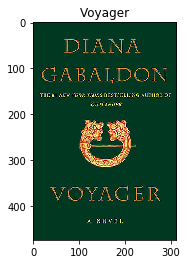

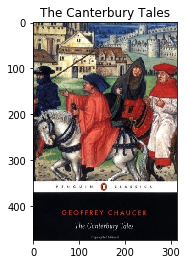

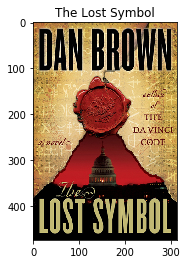

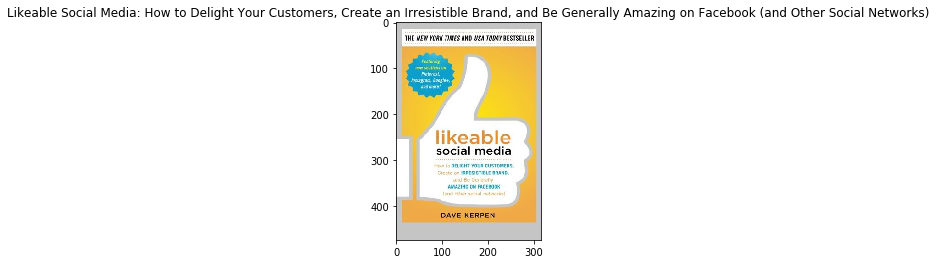

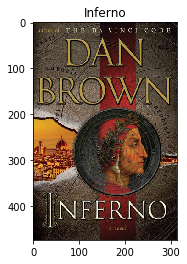

In [23]:
recommendations("The Da Vinci Code")

<ipython-input-17-90dd20a731cb>:17: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  avgword2vec = google_model[word]
<ipython-input-17-90dd20a731cb>:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  avgword2vec = avgword2vec + google_model[word]


[(1065, 0.9218726), (562, 0.911296), (317, 0.90753955), (840, 0.9062199), (167, 0.9053736)]


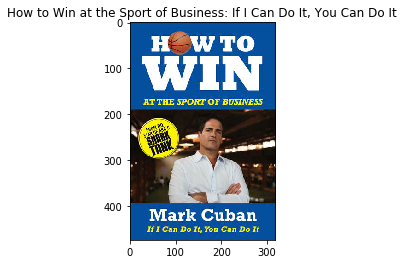

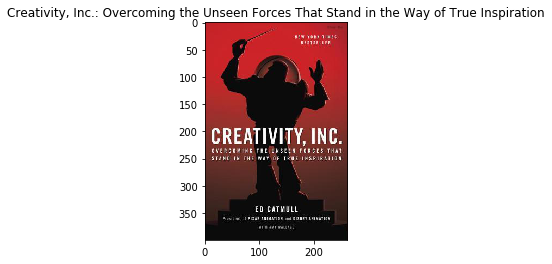

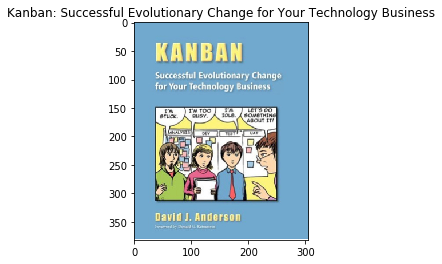

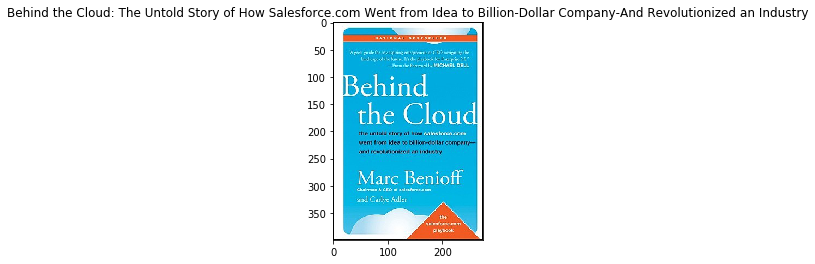

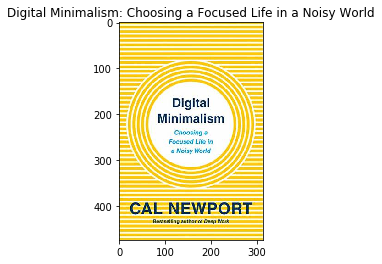

In [20]:
recommendations("Steve Jobs")

# Building TF-IDF Word2Vec Model

In [11]:
#Building TFIDF model and calculate TFIDF score

tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df = 5, stop_words='english')
# tfidf.fit(df['cleaned'])

tfidf_matrix = tfidf.fit_transform(df['cleaned'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Getting the words from the TF-IDF model

tfidf_list = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))
tfidf_feature = tfidf.get_feature_names() # tfidf words/col-names

In [ ]:
#Building TFIDF model and calculate TFIDF score

tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df = 5, stop_words='english')
# tfidf.fit(df['cleaned'])

tfidf_matrix = tfidf.fit_transform(df['cleaned'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Getting the words from the TF-IDF model

tfidf_list = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))
tfidf_feature = tfidf.get_feature_names() # tfidf words/col-names

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words="english")
# vectorizer = TfidfVectorizer()
CountVectorizer_matrix = vectorizer.fit_transform(df['cleaned'])
cosine_sim = cosine_similarity(CountVectorizer_matrix)




In [23]:
# Building TF-IDF Word2Vec 

# Storing the TFIDF Word2Vec embeddings
tfidf_vectors = []; 
line = 0;
# for each book description
for desc in corpus: 
  # Word vectors are of zero length (Used 300 dimensions)
    sent_vec = np.zeros(300) 
    # num of words with a valid vector in the book description
    weight_sum =0; 
    # for each word in the book description
    for word in desc: 
        if word in google_model.wv.vocab and word in tfidf_feature:
            vec = google_model.wv[word]
            tf_idf = tfidf_list[word] * (desc.count(word) / len(desc))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_vectors.append(sent_vec)
    line += 1

In [13]:
#Recommending top 5 similar books

def recommendations(title):
    
    # finding cosine similarity for the vectors

#     cosine_similarities = cosine_similarity(tfidf_matrix,  tfidf_matrix)
#     tfidf_matrix
#     cosine_similarities = cosine_similarity(tfidf_vectors,  tfidf_vectors)

    cosine_similarities = cosine_similarity(CountVectorizer_matrix,  CountVectorizer_matrix)
    # taking the title and book image link and store in new data frame called books
    books = df[['title', 'image_link']]
    #Reverse mapping of the index
    indices = pd.Series(df.index, index = df['title']).drop_duplicates()
         
    idx = indices[title]
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:6]
    print(sim_scores)
    book_indices = [i[0] for i in sim_scores]
    recommend = books.iloc[book_indices]
#     for index, row in recommend.iterrows():

#         response = requests.get(row['image_link'])
#         img = Image.open(BytesIO(response.content))
#         plt.figure()
#         plt.imshow(img)
#         plt.title(row['title'])
    return recommend

In [14]:
df.iloc[1577]

Unnamed: 0                                                   1645
Desc            First published in 1959, Shirley Jackson's The...
Unnamed: 0.1                                                  NaN
author                                            Shirley Jackson
genre                                                 Non-Fiction
image_link      https://i.gr-assets.com/images/S/compressed.ph...
rating                                                       3.84
title                                  The Haunting of Hill House
cleaned         first published 1959 shirley jackson s hauntin...
Name: 1577, dtype: object

In [16]:
recommendations("The Haunting of Hill House")

[(2164, 0.1790048145484045), (1801, 0.17730517688015487), (2187, 0.17118419700436519), (2123, 0.16597843248097038), (2126, 0.16485992856579973)]


,title,image_link
2164,Little House in the Big Woods,https://i.gr-assets.com/images/S/compressed.ph...
1801,Nine Perfect Strangers,https://i.gr-assets.com/images/S/compressed.ph...
2187,Little House on the Prairie,https://i.gr-assets.com/images/S/compressed.ph...
2123,A Painted House,https://i.gr-assets.com/images/S/compressed.ph...
2126,The House at Riverton,https://i.gr-assets.com/images/S/compressed.ph...


[(1582, 0.5895165776583204), (1286, 0.5425779185740991), (1216, 0.3921429601758788), (1144, 0.21100428090743806), (75, 0.1788405166018557)]


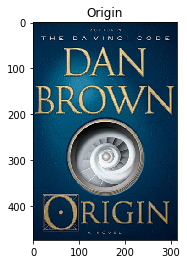

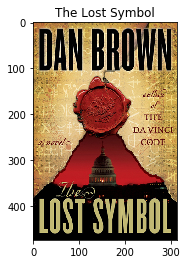

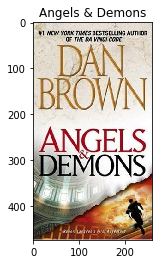

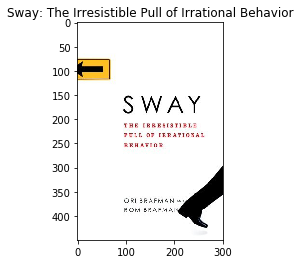

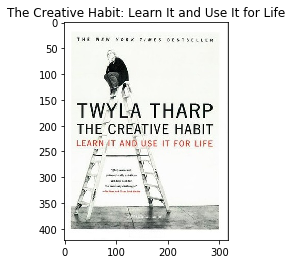

In [27]:
recommendations("The Da Vinci Code")

In [25]:
sim_score = pd.DataFrame([0,0,0], index= ['CountVectorizer', 'TF-IDF' , 'TF-IDF + Word2Vec' ], columns =['similarity score'])
sim_score.iloc[0,0]= 0.551
sim_score.iloc[1,0]= 0.1686
sim_score.iloc[2,0]= 0.702
sim_score

,similarity score
CountVectorizer,0.5510
TF-IDF,0.1686
TF-IDF + Word2Vec,0.7020


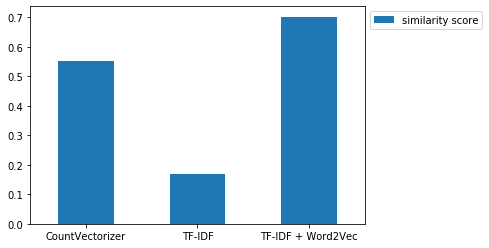

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
sim_score_plot = sim_score.plot.bar(y='similarity score', rot=0).legend(bbox_to_anchor=(1, 1))
